<a href="https://colab.research.google.com/github/Bangkit-Capstone-C241-BB01/BlurOrBokeh_ML_All/blob/main/TL_with_FFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Approach

## Setup

In [ ]:
import os
import sys
import PIL
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

PIL.Image.MAX_IMAGE_PIXELS = None

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
base_dir = "/content/drive/My Drive/Blur or Bokeh"

data_dir = os.path.join(base_dir, "Dataset")
library_dir = os.path.join(base_dir, "Library")
serialized_data_dir = os.path.join(base_dir, "Serialized Data")
braincore_data_dir = os.path.join(data_dir, "Braincore")

sys.path.append(library_dir)
from cf_matrix import make_confusion_matrix

## Load the Dataset

In [ ]:
image_size = (150, 150)
class_names = ["Blur", "Bokeh", "Normal"]

train_dir = os.path.join(braincore_data_dir, "train")
validation_dir = os.path.join(braincore_data_dir, "val")
test_dir = os.path.join(braincore_data_dir, "test")
combined_train_data_dir = os.path.join(data_dir, "Combined Training Data")


combine_train_data = False

if combine_train_data:
    import shutil

    scraped_data_dir = os.path.join(data_dir, "Scraped")
    kaggle_data_dir = os.path.join(data_dir, "Kaggle")
    train_data_dirs = [train_dir, scraped_data_dir, kaggle_data_dir]

    for train_data_dir in train_data_dirs:
        classes = os.listdir(train_data_dir)
        for cls in classes:
            cls_dir = os.path.join(train_data_dir, cls)
            combined_cls_dir = os.path.join(combined_train_data_dir, cls)
            if not os.path.exists(combined_cls_dir):
                os.makedirs(combined_cls_dir)
            for file in os.listdir(cls_dir):
                shutil.copy(os.path.join(cls_dir, file), combined_cls_dir)

train_dir = combined_train_data_dir

In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=fft_preprocessing,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="sparse"
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=fft_preprocessing,rescale=1./255)
validation_generator = train_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=32,
    class_mode="sparse"
)

test_datagen = ImageDataGenerator(
    preprocessing_function=fft_preprocessing,rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=2000,
    class_mode="sparse",
    shuffle=False
)

NameError: name 'fft_preprocessing' is not defined

In [ ]:
# def generator_to_dataset(generator):
#     output_signature = (
#         tf.TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32),  # Adjust shape as necessary
#         tf.TensorSpec(shape=(None,), dtype=tf.float32)
#     )

#     def gen():
#         for data, labels in generator:
#             yield data, labels

#     return tf.data.Dataset.from_generator(gen, output_signature=output_signature)

# # Convert generator to dataset
# train_dataset = generator_to_dataset(train_generator)
# validation_dataset = generator_to_dataset(validation_generator)
# test_dataset = generator_to_dataset(test_generator)

# # Apply FFT preprocessing to the dataset
# train_dataset = train_dataset.map(lambda x, y: (fft_preprocessing(x), y))
# validation_dataset = validation_dataset.map(lambda x, y: (fft_preprocessing(x), y))
# test_dataset = test_dataset.map(lambda x, y: (fft_preprocessing(x), y))

# # Prefetch for better performance
# train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# import numpy as np
# def custom_generator_with_fft(generator):
#     for batch_x, batch_y in generator:
#         batch_x_fft = np.zeros_like(batch_x)
#         for i in range(batch_x.shape[0]):
#             batch_x_fft[i] = fft_preprocessing(batch_x[i]).numpy()
#         yield batch_x_fft, batch_y

# # Create the custom generator
# train_generator_with_fft = custom_generator_with_fft(train_generator)
# validation_generator_with_fft = custom_generator_with_fft(validation_generator)
# test_generator_with_fft = custom_generator_with_fft(test_generator)


In [ ]:
test_generator_with_fft[0]

TypeError: 'generator' object is not subscriptable

## Build the Model

In [ ]:
pre_trained_model = InceptionV3(
    input_shape=image_size + (3,),
    include_top=False,
    weights="imagenet"
)
pre_trained_model.trainable = True

In [ ]:
last_layer = pre_trained_model.get_layer("mixed3")
last_layer = last_layer.output

x = tf.keras.layers.BatchNormalization()(last_layer)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(3, activation="softmax")(x)

# learning_rate=0.0001
model = Model(pre_trained_model.input, x)
model.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


## Train, Evaluate, and Save the Model

In [ ]:
class TestSetEvaluator(tf.keras.callbacks.Callback):
    def __init__(self, test_data, best_accuracy):
        super().__init__()
        self.test_data = test_data
        self.best_accuracy = best_accuracy

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_accuracy = self.model.evaluate(self.test_data, verbose=0)
        model_weights_filename = f"FFT + Transfer Learning Approach_{round(test_accuracy * 100)}.h5"

        if test_accuracy > self.best_accuracy:
            self.best_accuracy = test_accuracy
            self.model.save(os.path.join(serialized_data_dir, model_weights_filename))
            print(f'\===| Test accuracy improved to {test_accuracy:.4f} |===')

test_evaluator = TestSetEvaluator(test_generator, 0.7070)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[test_evaluator],
    epochs=2
)

Epoch 1/2
90/90 [==============================] - ETA: 0s - loss: 0.1376 - accuracy: 0.9486

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


\===| Test accuracy improved to 0.7719.
90/90 [==============================] - 100s 1s/step - loss: 0.1376 - accuracy: 0.9486 - val_loss: 0.4737 - val_accuracy: 0.8625
Epoch 2/2
90/90 [==============================] - 96s 1s/step - loss: 0.1500 - accuracy: 0.9427 - val_loss: 0.3878 - val_accuracy: 0.8844


In [ ]:
model_weights_filename = "FFT + Transfer Learning Approach_latest.h5"

In [ ]:
model.save_weights(os.path.join(serialized_data_dir, model_weights_filename))

In [ ]:
model.load_weights(os.path.join(serialized_data_dir, model_weights_filename))

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

1/1 [==============================] - 1s 1s/step - loss: 0.7869 - accuracy: 0.8070
Test Accuracy: 0.8070


In [ ]:
X_test[-1]

array([[[ 0.04567287, -0.07223797, -0.07223797],
        [-0.07223797, -0.07223797, -0.07223797],
        [-0.07223797, -0.07223797, -0.07223797],
        ...,
        [-0.07223797, -0.07223797, -0.07223797],
        [-0.07223797, -0.07223797, -0.07223797],
        [-0.07223797, -0.07223797, -0.07223797]],

       [[ 0.04567287, -0.07223797, -0.07223797],
        [-0.07223797, -0.07223797, -0.07223797],
        [-0.07223797, -0.07223797, -0.07223797],
        ...,
        [-0.07223797, -0.07223797, -0.07223797],
        [-0.07223797, -0.07223797, -0.07223797],
        [-0.07223797, -0.07223797, -0.07223797]],

       [[ 0.04567287, -0.07223797, -0.07223797],
        [-0.07223797, -0.07223797, -0.07223797],
        [-0.07223797, -0.07223797, -0.07223797],
        ...,
        [-0.07223797, -0.07223797, -0.07223797],
        [-0.07223797, -0.07223797, -0.07223797],
        [-0.07223797, -0.07223797, -0.07223797]],

       ...,

       [[ 0.04349649,  0.03888409,  0.03888409],
        [ 0

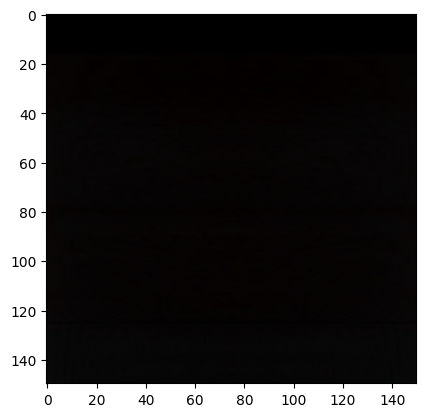

In [ ]:
plt.imshow(X_test[-1])

## Visualization

In [ ]:
X_test, y_test = next(test_generator)

### Confusion Matrix

4/4 [==============================] - 0s 23ms/step


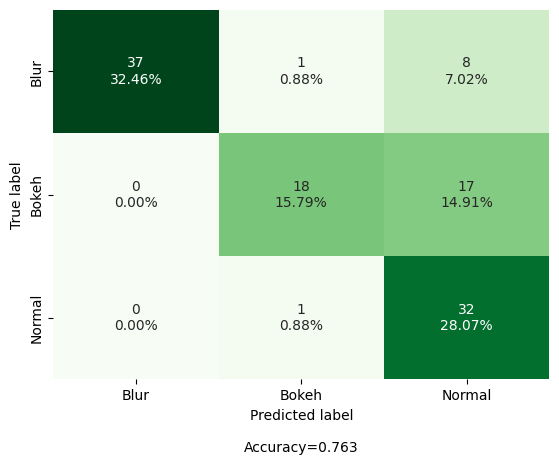

In [ ]:
test_pred = model.predict(X_test)
test_pred = tf.argmax(test_pred, axis=1)
cm = confusion_matrix(y_test, test_pred)
make_confusion_matrix(cm, categories=class_names, cmap="Greens", cbar=False)

In [ ]:
def fft_preprocessing(image):
    # Convert the image to float32 (if not already)
    image = tf.cast(image, tf.float32)

    # Apply FFT along the height and width axes
    image_fft = tf.signal.fft2d(tf.cast(image, tf.complex64))

    # Compute the magnitude of the FFT
    image_fft = tf.abs(image_fft)

    # Normalize the result
    image_fft = tf.math.log(image_fft + 1e-8)

    return image_fft

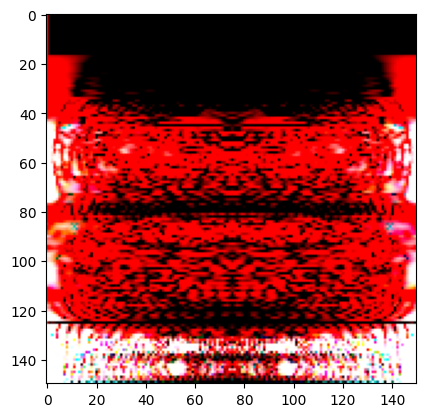

In [ ]:
plt.imshow(fft_preprocessing(X_test[-1]))

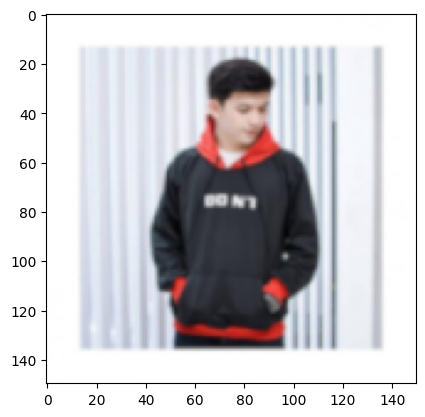

In [ ]:
plt.imshow(X_test[0])

### Error Analysis

In [ ]:
error_image = X_test[test_pred != y_test]
error_label = tf.cast(y_test[test_pred != y_test],tf.int32)
error_pred = test_pred[test_pred != y_test]

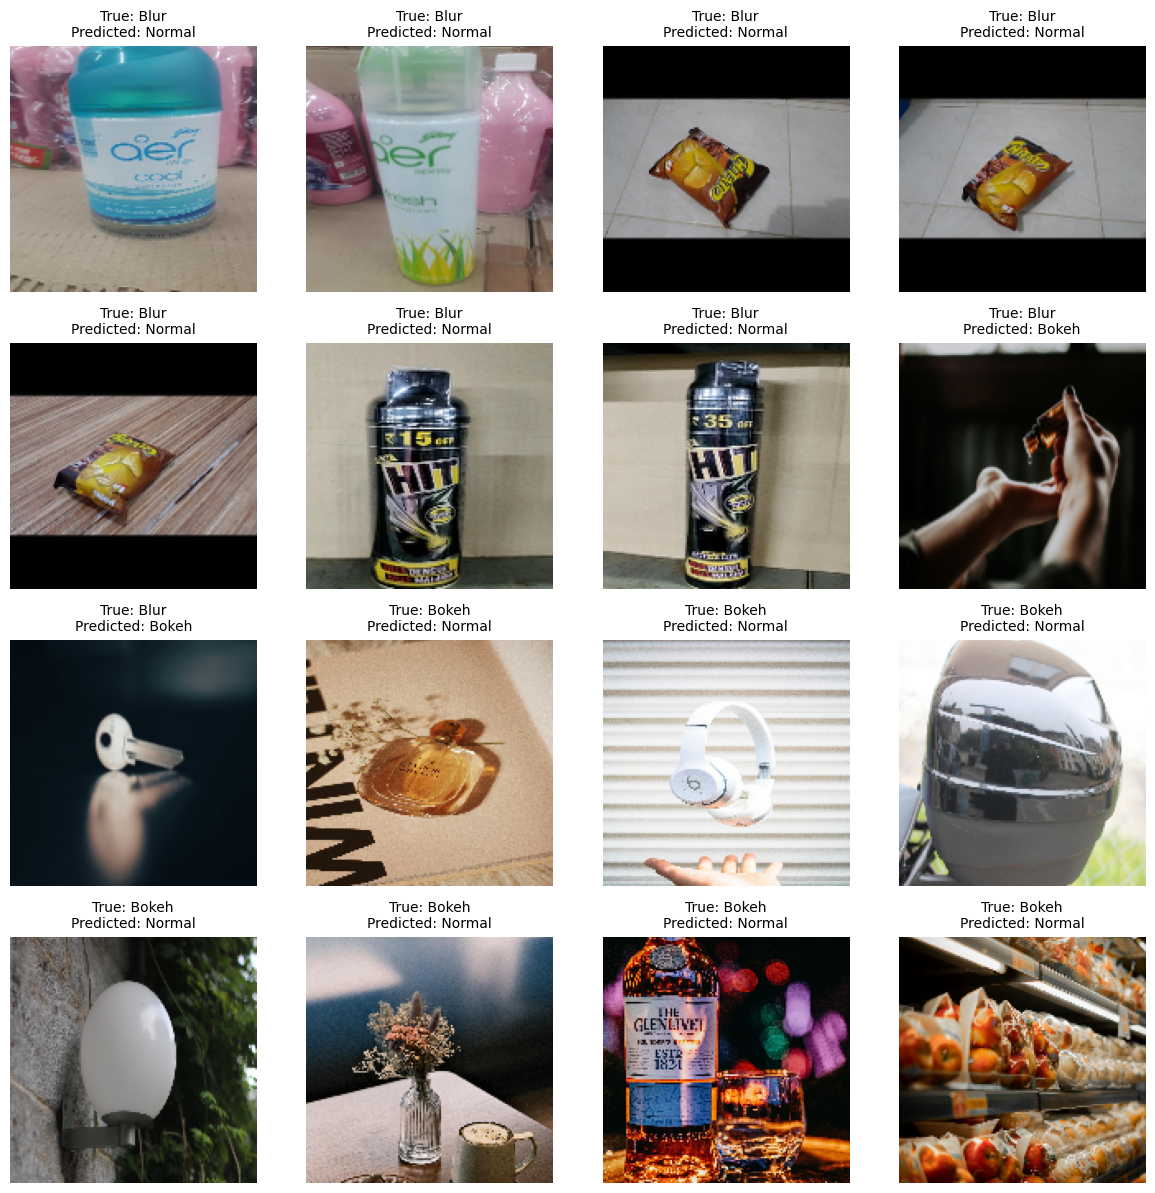

In [ ]:
num_row = 5
num_col = 4
subplot_size = 3
plt.figure(figsize=(num_col*subplot_size, num_row*subplot_size))
for i in range(len(error_image)):
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(error_image[i])
    plt.axis("off")
    plt.title(f"True: {class_names[error_label[i]]}\nPredicted: {class_names[error_pred[i]]}", fontsize=10)
plt.tight_layout()
plt.show()

### Model Architecture

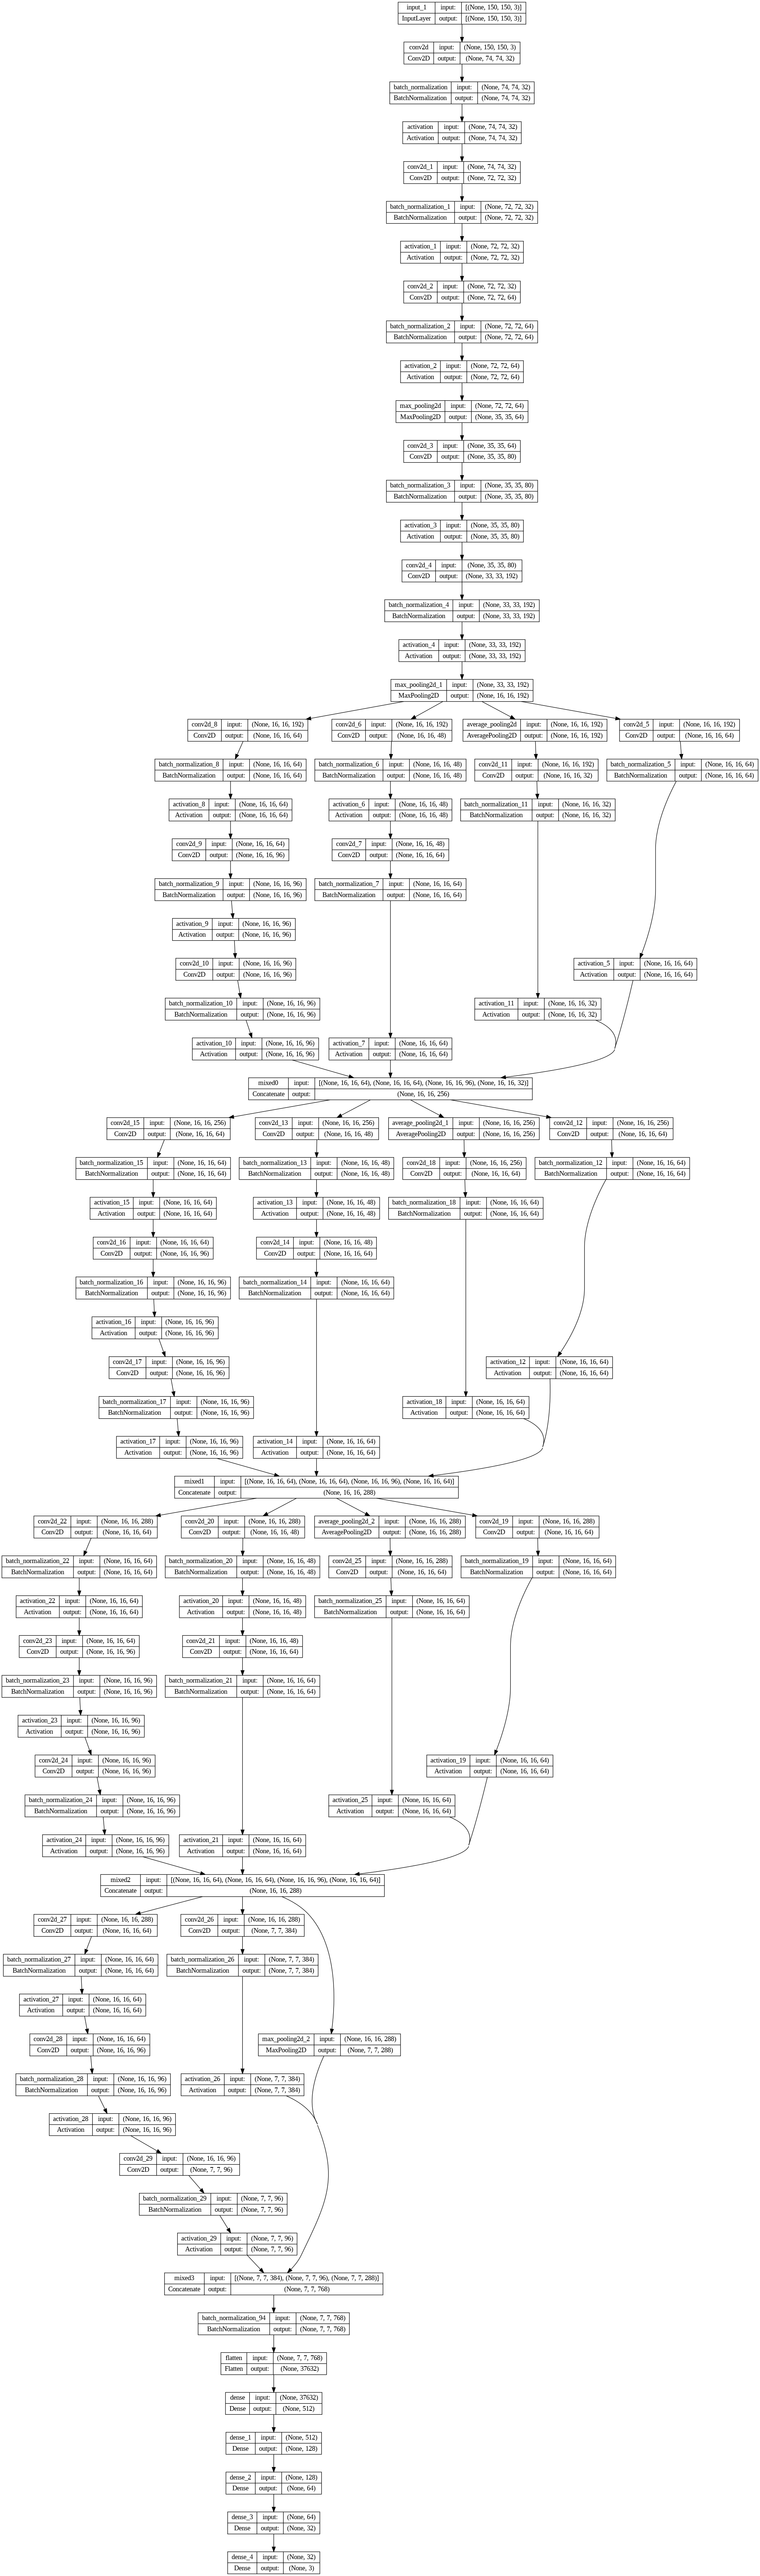

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)